In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np

In [2]:
def identity(x, *args, **kwargs):
    return x

def default(x, d):
    if x is None:
        return d if not isfunction(d) else d()
    return x

def cast_tuple(x):
    return x if isinstance(x, tuple) else (x,)

def cache_fn(f):
    cache = None
    @wraps(f)
    def cached_fn(*args, **kwargs):
        nonlocal cache
        if cache is not None:
            return cache
        cache = f(*args, **kwargs)
        return cache
    return cached_fn

def to(t):
    return {'device': t.device, 'dtype': t.dtype}

def find_modules(nn_module, type):
    return [module for module in nn_module.modules() if isinstance(module, type)]

def is_empty(t):
    return t.nelement() == 0

def max_neg_value(tensor):
    return -torch.finfo(tensor.dtype).max

def batched_index_select(values, indices):
    last_dim = values.shape[-1]
    return values.gather(2, expand_dim(indices, -1, last_dim))

def merge_dims(ind_from, ind_to, tensor):
    shape = list(tensor.shape)
    arr_slice = slice(ind_from, ind_to + 1)
    shape[arr_slice] = [reduce(mul, shape[arr_slice])]
    return tensor.reshape(*shape)

def expand_dim(t, dim, k):
    t = t.unsqueeze(dim)
    expand_shape = [-1] * len(t.shape)
    expand_shape[dim] = k
    return t.expand(*expand_shape)

def scatter_mean(src, t, index, dim, eps = 1e-5):
    numer = src.scatter_add(dim, index, t)
    denom = src.scatter_add(dim, index, torch.ones_like(t))
    return numer / (denom + eps)

def split_at_index(dim, index, t):
    pre_slices = (slice(None),) * dim
    l = (*pre_slices, slice(None, index))
    r = (*pre_slices, slice(index, None))
    return t[l], t[r]

def ema(old, new, decay):
    if old is None:
        return new
    return old * decay + new * (1 - decay)

def ema_inplace(moving_avg, new, decay):
    if is_empty(moving_avg):
        moving_avg.data.copy_(new)
        return
    moving_avg.data.mul_(decay).add_(new, alpha= (1 - decay))

# helper classes

class Chunk(nn.Module):
    def __init__(self, chunks, fn, along_dim = -1):
        super().__init__()
        self.dim = along_dim
        self.chunks = chunks
        self.fn = fn

    def forward(self, x, **kwargs):
        if self.chunks <= 1:
            return self.fn(x, **kwargs)
        chunks = x.chunk(self.chunks, dim = self.dim)
        return torch.cat([self.fn(c, **kwargs) for c in chunks], dim = self.dim)

class PreNorm(nn.ModuleList):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        x = self.norm(x)
        return self.fn(x, **kwargs)

class ProjectInOut(nn.Module):
    def __init__(self, fn, dim_in, dim_out, project_out = True):
        super().__init__()
        self.fn = fn
        self.project_in = nn.Linear(dim_in, dim_out)
        self.project_out = nn.Linear(dim_out, dim_in) if project_out else identity

    def forward(self, x, **kwargs):
        x = self.project_in(x)
        x, loss = self.fn(x, **kwargs)
        x = self.project_out(x)
        return x, loss

# kmeans related function and class

def update_kmeans_on_backwards(module):
    module.kmean_modules = find_modules(module, Kmeans)
    def hook(_, grad_in, grad_out):
        for m in module.kmean_modules:
            m.update()

    return module.register_backward_hook(hook)

def similarity(x, means):
    return torch.einsum('bhld,hcd->bhlc', x, means)

def dists_and_buckets(x, means):
    dists = similarity(x, means)
    _, buckets = torch.max(dists, dim=-1)
    return dists, buckets

def batched_bincount(index, num_classes, dim=-1):
    shape = list(index.shape)
    shape[dim] = num_classes
    out = index.new_zeros(shape)
    out.scatter_add_(dim, index, torch.ones_like(index, dtype=index.dtype))
    return out

def kmeans_iter(x, means, buckets = None):
    b, h, l, d, dtype, num_clusters = *x.shape, x.dtype, means.shape[1]

    if buckets is None:
        _, buckets = dists_and_buckets(x, means)

    bins = batched_bincount(buckets, num_clusters).sum(0, keepdim=True)
    zero_mask = bins.long() == 0

    means_ = buckets.new_zeros(b, h, num_clusters, d, dtype=dtype)
    means_.scatter_add_(-2, expand_dim(buckets, -1, d), x)
    means_ = F.normalize(means_.sum(0, keepdim=True), dim=-1).type(dtype)

    means = torch.where(zero_mask.unsqueeze(-1), means, means_)
    means = means.squeeze(0)
    return means

def distribution(dists, window_size):
    _, topk_indices = dists.topk(k=window_size, dim=-2)
    indices = topk_indices.transpose(-2, -1)
    return indices.reshape(*indices.size()[:2], -1)

In [3]:
from inspect import isfunction

In [4]:
TOKEN_SELF_ATTN_VALUE = -5e4
KMEAN_INIT_ITERS = 10

In [5]:
class RoutingTransformer(nn.Module):
    def __init__(self, num_layers, num_heads, d_model, d_ff, dropout):
        super().__init__()

        self.positional_encoding = PositionalEncoding(d_model=d_model, dropout=dropout)

        self.encoder_layers = nn.ModuleList([EncoderLayer(num_heads=num_heads, d_model=d_model, d_ff=d_ff, dropout=dropout) for _ in range(num_layers)])
#        self.decoder_layers = nn.ModuleList([DecoderLayer(num_heads=num_heads, d_model=d_model, d_ff=d_ff, dropout=dropout) for _ in range(num_layers)])

        self.flatten = nn.Flatten()
        self.final_layer = nn.Linear(d_model, 1)
        
    def forward(self, input_ids):

        input_embeddings = input_ids

        # Apply positional encoding
        input_embeddings = self.positional_encoding(input_embeddings)

        # Encode inputs
        for layer in self.encoder_layers:
            input_embeddings = layer(input_embeddings)


        output=torch.mean(input_embeddings,dim=1,keepdim=False)
        output = F.relu(self.flatten(output))
        output = self.final_layer(output)
        
        return output

In [6]:
class EncoderLayer(nn.Module):
    def __init__(self, num_heads, d_model, d_ff, dropout):
        super().__init__()

        self.multihead_attention = KmeansAttention(num_clusters=4, window_size=8, num_heads=num_heads, head_dim=int(d_model/num_heads))
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.positionwise_feedforward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout),
        )
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.num_heads = num_heads
        self.d_model = d_model

    def forward(self, x):
        
        b, t, e, h, dh = *x.shape, self.num_heads, self.d_model
        split_heads = lambda v: v.reshape(b, -1, h, int(dh/h)).transpose(1, 2).contiguous()
        q, k, v = map(split_heads, (x, x, x))
        
        attention_output, _ = self.multihead_attention(q, k, v)
        attention_output = attention_output.reshape(b, t, e)
        x = self.layer_norm1(x + self.dropout(attention_output))
        feedforward_output = self.positionwise_feedforward(x)
        x = self.layer_norm2(x + self.dropout(feedforward_output))
        return x

In [7]:
class Kmeans(nn.Module):
    def __init__(self, num_heads, head_dim, num_clusters, ema_decay = 0.999, commitment = 1e-4):
        super().__init__()
        self.commitment = commitment
        self.ema_decay = ema_decay

        self.register_buffer('means', torch.randn(num_heads, num_clusters, head_dim))
        self.register_buffer('initted', torch.tensor(False))
        self.num_new_means = 0
        self.new_means = None

    @torch.no_grad()
    def init(self, x):
        if self.initted:
            return
        _, h, _, d, device, dtype = *x.shape, x.device, x.dtype

        num_clusters = self.means.shape[1]

        means = x.transpose(0, 1).contiguous().view(h, -1, d)
        num_samples = means.shape[1]

        if num_samples >= num_clusters:
            indices = torch.randperm(num_samples, device=device)[:num_clusters]
        else:
            indices = torch.randint(0, num_samples, (num_clusters,), device=device)

        means = means[:, indices]

        for _ in range(KMEAN_INIT_ITERS):
            means = kmeans_iter(x, means)

        self.num_new_means = 0
        self.means.data.copy_(means)
        self.initted.data.copy_(torch.tensor(True))

    @torch.no_grad()
    def update(self, new_means = None):
        new_means = default(new_means, self.new_means)
        assert new_means is not None, 'new kmeans has not been supplied'
        ema_inplace(self.means, new_means, self.ema_decay)

        del self.new_means
        self.new_means = None
        self.num_new_means = 0

    def forward(self, x, update_means = False):
        self.init(x)

        b, dtype = x.shape[0], x.dtype
        means = self.means.type(dtype)
        x = F.normalize(x, 2, dim=-1).type(dtype)

        with torch.no_grad():
            dists, buckets = dists_and_buckets(x, means)

        routed_means = batched_index_select(expand_dim(means, 0, b), buckets)
        loss = F.mse_loss(x, routed_means) * self.commitment

        if update_means:
            with torch.no_grad():
                means = kmeans_iter(x, means, buckets)
            self.new_means = ema(self.new_means, means, self.num_new_means / (self.num_new_means + 1))
            self.num_new_means += 1

        return dists, loss

In [8]:
class KmeansAttention(nn.Module):
    def __init__(self, num_clusters, window_size, num_heads, head_dim, causal = False, dropout = 0., ema_decay = 0.999, commitment = 1e-4, context_window_size = None, receives_context = False, num_mem_kv = 0, shared_qk = False):
        super().__init__()
        self.num_heads = num_heads
        self.num_clusters = num_clusters
        self.head_dim = head_dim

        self.window_size = window_size
        self.context_window_size = default(context_window_size, window_size)
        self.causal = causal

        self.shared_qk = shared_qk
        self.receives_context = receives_context
        self.kmeans = Kmeans(num_heads, head_dim, num_clusters, ema_decay, commitment)
        self.dropout = nn.Dropout(dropout)

        self.num_mem_kv = max(num_mem_kv, 1 if causal and not shared_qk else 0)
        self.mem_key = nn.Parameter(torch.randn(num_heads, num_clusters, self.num_mem_kv, head_dim))
        self.mem_value = nn.Parameter(torch.randn(num_heads, num_clusters, self.num_mem_kv, head_dim))

    def forward(self, q, k, v, query_mask = None, key_mask = None, **kwargs):
        b, h, t, d, kv_t, wsz, c_wsz, nc, device, dtype = *q.shape, k.shape[2], self.window_size, self.context_window_size, self.num_clusters, q.device, q.dtype
        is_reverse = kwargs.pop('_reverse', False)

        out = torch.zeros_like(q, dtype=dtype)

        update_kmeans = self.training and not is_reverse
        
        key_mask = default(key_mask, query_mask) if not self.receives_context else key_mask
        kv_wsz = wsz if not self.receives_context else c_wsz

        wsz = min(wsz, t)
        kv_wsz = min(kv_wsz, kv_t)

        if not self.shared_qk or self.receives_context:
            dists, aux_loss = self.kmeans(torch.cat((q, k), dim=2), update_kmeans)
            q_dists, k_dists = split_at_index(2, t, dists)
            indices = distribution(q_dists, wsz)
            kv_indices = distribution(k_dists, kv_wsz)
        else:
            dists, aux_loss = self.kmeans(q, update_kmeans)
            k = F.normalize(k, dim=-1).to(q)
            indices = distribution(dists, wsz)
            kv_indices = indices

        q = batched_index_select(q, indices)
        k = batched_index_select(k, kv_indices)
        v = batched_index_select(v, kv_indices)

        reshape_with_window = lambda x: x.reshape(b, h, nc, -1, d)
        q, k, v = map(reshape_with_window, (q, k, v))

        m_k, m_v = map(lambda x: expand_dim(x, 0, b).to(q), (self.mem_key, self.mem_value))
        k, v = map(lambda x: torch.cat(x, dim=3), ((m_k, k), (m_v, v)))

        dots = torch.einsum('bhnid,bhnjd->bhnij', q, k) * (d ** -0.5)

        mask_value = max_neg_value(dots)

        if query_mask is not None or key_mask is not None:
            query_mask = default(query_mask, lambda: torch.ones((b, t), device=device).bool())
            key_mask = default(key_mask, lambda: torch.ones((b, kv_t), device=device).bool())

            q_mask = expand_dim(query_mask, 1, h).gather(2, indices)
            kv_mask = expand_dim(key_mask, 1, h).gather(2, kv_indices)
            q_mask, kv_mask = map(lambda t: t.reshape(b, h, nc, -1), (q_mask, kv_mask))
            mask = q_mask[:, :, :, :, None] * kv_mask[:, :, :, None, :]
            mask = F.pad(mask, (self.num_mem_kv, 0), value=True)
            dots.masked_fill_(~mask, mask_value)
            del mask

        if self.causal:
            q_mask, kv_mask = map(lambda t: t.reshape(b, h, nc, -1), (indices, kv_indices))
            mask = q_mask[:, :, :, :, None] >= kv_mask[:, :, :, None, :]
            mask = F.pad(mask, (self.num_mem_kv, 0), value=True)
            dots.masked_fill_(~mask, mask_value)
            del mask            

        if self.shared_qk:
            q_mask, kv_mask = map(lambda t: t.reshape(b, h, nc, -1), (indices, kv_indices))
            mask = q_mask[:, :, :, :, None] == kv_mask[:, :, :, None, :]
            mask = F.pad(mask, (self.num_mem_kv, 0), value=False)
            dots.masked_fill_(mask, TOKEN_SELF_ATTN_VALUE)
            del mask

        dots = dots.softmax(dim=-1)
        dots = self.dropout(dots)

        bo = torch.einsum('bhcij,bhcjd->bhcid', dots, v)
        so = torch.reshape(bo, (b, h, -1, bo.shape[-1])).type(dtype)
        out = scatter_mean(out, so, indices.unsqueeze(-1).expand_as(so), -2)
        return out, aux_loss

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=20):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) #.transpose(0, 1)
        self.register_buffer('pe', pe)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = x + self.pe.repeat(x.size(0),1,1)
        x = self.dropout(x)
        return x

In [10]:
num_layers = 2
num_heads = 2
d_model = 22
d_ff = 64
dropout = 0
model = RoutingTransformer(num_layers=num_layers, num_heads=num_heads, d_model=d_model, d_ff=d_ff, dropout=dropout)

input_ids = torch.rand(2,20,22)
output = model(input_ids)
print(output.shape)
print(output)

torch.Size([2, 1])
tensor([[0.1621],
        [0.0944]], grad_fn=<AddmmBackward0>)


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [12]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)

In [13]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [14]:
df_for_training=df[feature_names].astype(float)

In [15]:
scaler=MinMaxScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [16]:
trainX=[]
trainY=[]

In [17]:
n_future=1
n_past=20

In [18]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [19]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [20]:
trainX_copy,trainY_copy=trainX.copy(),trainY.copy()

In [21]:
data,label=trainX,trainY

In [22]:
def standardization(data):
    mu = np.min(data)
    sigma = np.max(data)-np.min(data)
    return (data - mu) / sigma

In [23]:
for j in range(0,data.shape[2]):
    data[:,:,j]=standardization(data[:,:,j])

In [24]:
label=standardization(label)

In [25]:
data = torch.from_numpy(data).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data,  label)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=False)

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0 )
criterion = nn.L1Loss()

In [27]:
for epoch in range(1000):
    
    losses = []
    for batch_idx, (data1, targets) in enumerate(train_loader):
        #import pdb;pdb.set_trace()
        output = model(data1)
       
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
    
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())

    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 3.1721913814544678
Epoch: 1 Loss: 1.7100847959518433
Epoch: 2 Loss: 1.2188093662261963
Epoch: 3 Loss: 1.03421950340271
Epoch: 4 Loss: 0.8380513787269592
Epoch: 5 Loss: 0.7802698016166687
Epoch: 6 Loss: 0.8383060097694397
Epoch: 7 Loss: 0.7434133291244507
Epoch: 8 Loss: 0.7442254424095154
Epoch: 9 Loss: 0.6723921895027161
Epoch: 10 Loss: 0.6218532919883728
Epoch: 11 Loss: 0.6161613464355469
Epoch: 12 Loss: 0.6482693552970886
Epoch: 13 Loss: 0.5784534215927124
Epoch: 14 Loss: 0.699831485748291
Epoch: 15 Loss: 0.5681807994842529
Epoch: 16 Loss: 0.5604642629623413
Epoch: 17 Loss: 0.5749828219413757
Epoch: 18 Loss: 0.6297023296356201
Epoch: 19 Loss: 0.5453490614891052
Epoch: 20 Loss: 0.640917956829071
Epoch: 21 Loss: 0.5722455978393555
Epoch: 22 Loss: 0.5666486024856567
Epoch: 23 Loss: 0.5778822898864746
Epoch: 24 Loss: 0.5629711747169495
Epoch: 25 Loss: 0.54184889793396
Epoch: 26 Loss: 0.5909041166305542
Epoch: 27 Loss: 0.5386396646499634
Epoch: 28 Loss: 0.5301952362060547
E

Epoch: 230 Loss: 0.3630688190460205
Epoch: 231 Loss: 0.36787861585617065
Epoch: 232 Loss: 0.4256829023361206
Epoch: 233 Loss: 0.4018721282482147
Epoch: 234 Loss: 0.37905222177505493
Epoch: 235 Loss: 0.5889275074005127
Epoch: 236 Loss: 0.3768206834793091
Epoch: 237 Loss: 0.43997347354888916
Epoch: 238 Loss: 0.35154595971107483
Epoch: 239 Loss: 0.4389089345932007
Epoch: 240 Loss: 0.3618676960468292
Epoch: 241 Loss: 0.38015270233154297
Epoch: 242 Loss: 0.509436845779419
Epoch: 243 Loss: 0.3566313087940216
Epoch: 244 Loss: 0.39965716004371643
Epoch: 245 Loss: 0.36462005972862244
Epoch: 246 Loss: 0.42487964034080505
Epoch: 247 Loss: 0.39213788509368896
Epoch: 248 Loss: 0.4227214753627777
Epoch: 249 Loss: 0.36900973320007324
Epoch: 250 Loss: 0.37279796600341797
Epoch: 251 Loss: 0.4116363823413849
Epoch: 252 Loss: 0.35842084884643555
Epoch: 253 Loss: 0.4144074022769928
Epoch: 254 Loss: 0.4724191129207611
Epoch: 255 Loss: 0.4706481397151947
Epoch: 256 Loss: 0.3914773464202881
Epoch: 257 Loss: 

Epoch: 456 Loss: 0.3564334213733673
Epoch: 457 Loss: 0.36120322346687317
Epoch: 458 Loss: 0.37578994035720825
Epoch: 459 Loss: 0.45975592732429504
Epoch: 460 Loss: 0.36488157510757446
Epoch: 461 Loss: 0.4413626194000244
Epoch: 462 Loss: 0.3320855498313904
Epoch: 463 Loss: 0.4937547743320465
Epoch: 464 Loss: 0.33272016048431396
Epoch: 465 Loss: 0.41188183426856995
Epoch: 466 Loss: 0.3272058963775635
Epoch: 467 Loss: 0.3683041036128998
Epoch: 468 Loss: 0.351593554019928
Epoch: 469 Loss: 0.43769899010658264
Epoch: 470 Loss: 0.3452053964138031
Epoch: 471 Loss: 0.44178909063339233
Epoch: 472 Loss: 0.36904972791671753
Epoch: 473 Loss: 0.4510010778903961
Epoch: 474 Loss: 0.34117889404296875
Epoch: 475 Loss: 0.3317711353302002
Epoch: 476 Loss: 0.36050742864608765
Epoch: 477 Loss: 0.36731773614883423
Epoch: 478 Loss: 0.3429369330406189
Epoch: 479 Loss: 0.3795534372329712
Epoch: 480 Loss: 0.3558475971221924
Epoch: 481 Loss: 0.40134283900260925
Epoch: 482 Loss: 0.3489886522293091
Epoch: 483 Loss:

Epoch: 682 Loss: 0.3513057827949524
Epoch: 683 Loss: 0.3317599892616272
Epoch: 684 Loss: 0.3477408289909363
Epoch: 685 Loss: 0.2982666492462158
Epoch: 686 Loss: 0.3372683525085449
Epoch: 687 Loss: 0.3168260455131531
Epoch: 688 Loss: 0.3417615592479706
Epoch: 689 Loss: 0.31918004155158997
Epoch: 690 Loss: 0.3447496294975281
Epoch: 691 Loss: 0.34755033254623413
Epoch: 692 Loss: 0.3578566014766693
Epoch: 693 Loss: 0.3099224865436554
Epoch: 694 Loss: 0.3525669574737549
Epoch: 695 Loss: 0.3339424133300781
Epoch: 696 Loss: 0.3944825828075409
Epoch: 697 Loss: 0.4470105767250061
Epoch: 698 Loss: 0.3151145875453949
Epoch: 699 Loss: 0.358530730009079
Epoch: 700 Loss: 0.3078332841396332
Epoch: 701 Loss: 0.31531476974487305
Epoch: 702 Loss: 0.3861313760280609
Epoch: 703 Loss: 0.306345134973526
Epoch: 704 Loss: 0.3551878333091736
Epoch: 705 Loss: 0.3059617578983307
Epoch: 706 Loss: 0.45551973581314087
Epoch: 707 Loss: 0.30624258518218994
Epoch: 708 Loss: 0.44380903244018555
Epoch: 709 Loss: 0.32080

Epoch: 908 Loss: 0.3566248416900635
Epoch: 909 Loss: 0.27986595034599304
Epoch: 910 Loss: 0.2858000695705414
Epoch: 911 Loss: 0.3331041634082794
Epoch: 912 Loss: 0.3220188021659851
Epoch: 913 Loss: 0.3291322588920593
Epoch: 914 Loss: 0.29073575139045715
Epoch: 915 Loss: 0.31077656149864197
Epoch: 916 Loss: 0.30915436148643494
Epoch: 917 Loss: 0.346609890460968
Epoch: 918 Loss: 0.37067535519599915
Epoch: 919 Loss: 0.3520761728286743
Epoch: 920 Loss: 0.3120088279247284
Epoch: 921 Loss: 0.3715052604675293
Epoch: 922 Loss: 0.29186147451400757
Epoch: 923 Loss: 0.3606814444065094
Epoch: 924 Loss: 0.2768488824367523
Epoch: 925 Loss: 0.3444133400917053
Epoch: 926 Loss: 0.2707854211330414
Epoch: 927 Loss: 0.3562018871307373
Epoch: 928 Loss: 0.2757326662540436
Epoch: 929 Loss: 0.3962115943431854
Epoch: 930 Loss: 0.2937444746494293
Epoch: 931 Loss: 0.3649962246417999
Epoch: 932 Loss: 0.26840323209762573
Epoch: 933 Loss: 0.33302173018455505
Epoch: 934 Loss: 0.2864561080932617
Epoch: 935 Loss: 0.45

In [28]:
trainX_copy_=trainX_copy
trainY_copy_=trainY_copy

In [29]:
for j in range(0,trainX_copy_.shape[2]):
    trainX_copy_[:,:,j]=standardization(trainX_copy_[:,:,j])

In [30]:
trainY_copy_=standardization(trainY_copy_)

In [31]:
test_data = torch.from_numpy(trainX_copy_).float()
test_label = torch.from_numpy(trainY_copy_).float()
test_dataset = TensorDataset(test_data, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [32]:
predictions=[]
for batch_idx, (data, targets) in enumerate(test_loader):
    output=model(data)
    predictions+=output.tolist()

In [33]:
predictions = np.array(predictions)

In [34]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

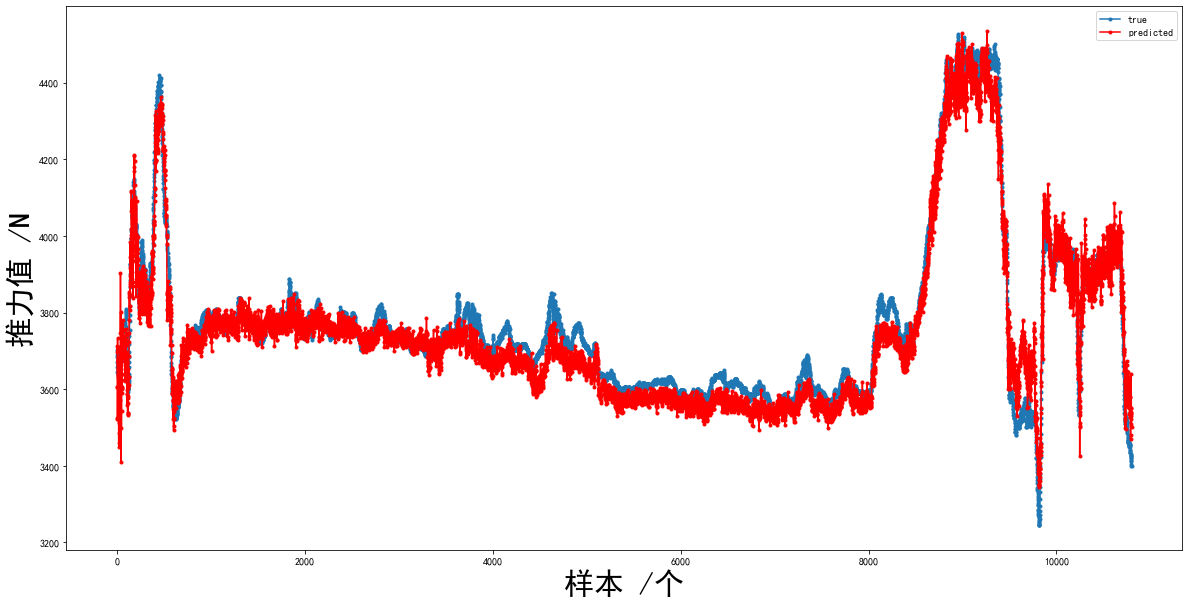

In [38]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot((predictions*19043.454262518393+23.9856747376088)[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend(); 